In [191]:
import imageio
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Rescaling

In [192]:
from sklearn.model_selection import train_test_split

data_dir = "face_age"

batch_size = 32
img_height = 200
img_width = 200


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height // 2, img_width // 2),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height // 2, img_width // 2),
  batch_size=batch_size)

Found 9778 files belonging to 11 classes.
Using 7823 files for training.
Found 9778 files belonging to 11 classes.
Using 1955 files for validation.


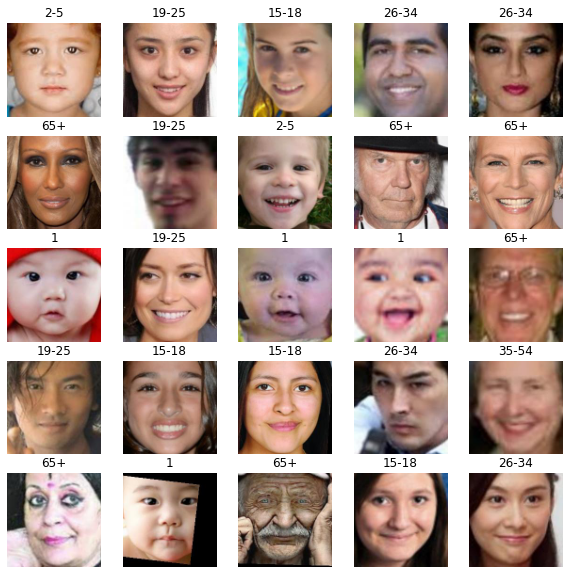

In [193]:
# Shows 25 random images from the training dataset
def display_data():
    class_names = train_ds.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
display_data()

In [194]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

# keeps images in memory after they are loaded in the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
rest_ds = rest_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [195]:
normalization_layer = layers.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [225]:
from tensorflow.keras.regularizers import l2
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height // 2,
                                  img_width // 2,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
Regularizer = l2(0.02)
model = Sequential([
#   data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu', activity_regularizer=Regularizer),
  layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', activity_regularizer=Regularizer),
  layers.Dense(num_classes)
])


In [226]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
245/245 [==============================] - 12s 46ms/step - loss: 21.6011 - accuracy: 0.2047 - val_loss: 2.2627 - val_accuracy: 0.3192
Epoch 2/20
245/245 [==============================] - 11s 46ms/step - loss: 2.0567 - accuracy: 0.3579 - val_loss: 1.9318 - val_accuracy: 0.3949
Epoch 3/20
245/245 [==============================] - 11s 46ms/step - loss: 1.8121 - accuracy: 0.4282 - val_loss: 1.7703 - val_accuracy: 0.4271
Epoch 4/20
245/245 [==============================] - 11s 46ms/step - loss: 1.6382 - accuracy: 0.4879 - val_loss: 1.6456 - val_accuracy: 0.4517
Epoch 5/20
245/245 [==============================] - 12s 48ms/step - loss: 1.4915 - accuracy: 0.5451 - val_loss: 1.5579 - val_accuracy: 0.4824
Epoch 6/20
245/245 [==============================] - 11s 46ms/step - loss: 1.3681 - accuracy: 0.5855 - val_loss: 1.5099 - val_accuracy: 0.5018
Epoch 7/20
245/245 [==============================] - 11s 45ms/step - loss: 1.2555 - accuracy: 0.6308 - val_loss: 1.4926 - val_accuracy

This image most likely belongs to 15-18 with a 62.99 percent confidence.
This image most likely belongs to 26-34 with a 90.91 percent confidence.
This image most likely belongs to 65+ with a 99.84 percent confidence.
This image most likely belongs to 65+ with a 99.93 percent confidence.
This image most likely belongs to 65+ with a 93.89 percent confidence.


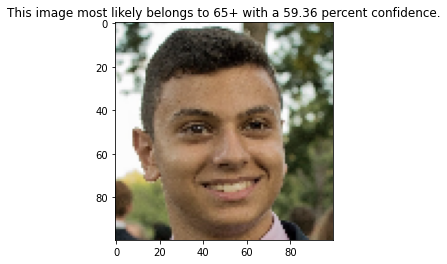

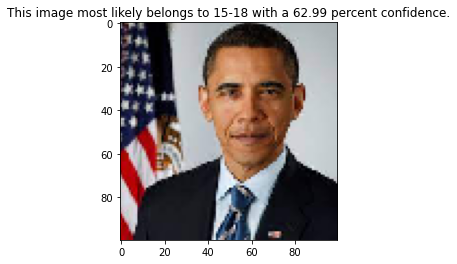

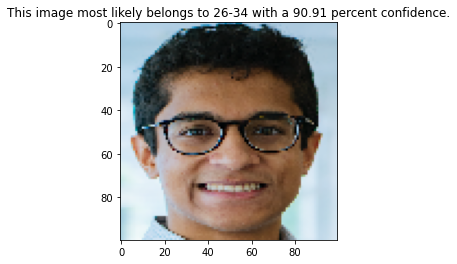

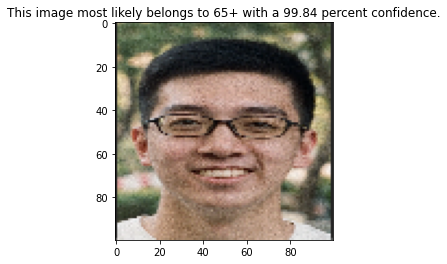

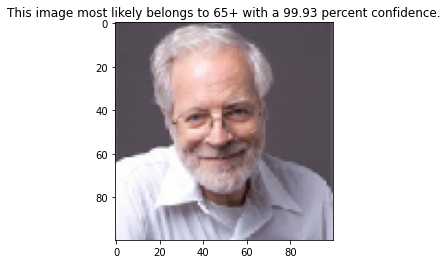

In [223]:
import os
test_dir = "test"

for filename in os.listdir(test_dir):
    img_file = os.path.join(test_dir, filename)
    try:
        img = tf.keras.utils.load_img(
            img_file, target_size=(img_height // 2, img_width // 2)
        )
        plt.figure()
        plt.imshow(img)
        plt.title("This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score)))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )
    except:
        continue